# 使用字符级RNN对姓名进行分类

## 1. 数据准备
数据下载通道: 点击[这里](https://download.pytorch.org/tutorial/data.zip)下载数据集。解压到当前工作目录。

在 `data/names` 文件夹下面包含18个名字形如 `[language].txt`的文件。每个文件包含多条姓名，一个姓名一行。我们在之后需要将其编码格式(Unicode)转化为ASCII。

通过下面的步骤，我们可以得到一个数据字典，形如`{language:[name1,name2,...]}` ，字典的键为语言，值为一个列表，包含对应文件夹下面的所有姓名。用变量 `category` 和 `line` 分别标识键值对

In [2]:
from __future__ import unicode_literals, print_function, division

from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!= 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictinary, a list of names per language
category_lines={}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


现在我们有了`category_lines`, 这是一个字典映射了每个语言和对应的名字。我们同样记录了 `all_categories`(一个包含所有语言的列表)和 `n_categories` 方便后续的引用

In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 2. 将姓名转化为张量
现在我们将所有的姓名组织好了，我们需要将他们转化为张量(Tensor)方便使用。  

为了表示单个字母，我们使用 **one-hot** 表示方法(size:`<1 x n_letters>`) 。一个 one-hot 向量是全0(激活字母为1)的向量。 例如:
`"b"=<0,1,0,0,0,...,0>`。

于是每个姓名可以用形状为 `<line_length x 1 x n_letters>` 的 2D 矩阵表示。

额外的一个维度是为了构建一个假的 batch(pytorch只接受mini_batch数据)

In [4]:
import torch

# Fine letter index from all_letters, e.g. "a"=0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)]=1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one_hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)]=1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())
    

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


## 3. 构建网络
在 `autograd` 出现前, 在Torch中创建一个循环神经网络需要在每一个时间步克隆层参数。网络层持有一个隐藏状态和梯度信息，而目前这些完全交由计算图本身来处理。这意味着你能自己用一个很纯净的方式来实现一个 RNN——仅仅使用一些常规的前馈层。

这个RNN模块只有两个线性层，以输入和隐藏状态为输入，LogsSoftmax 层为输出。

如下图所示：
![](https://i.imgur.com/Z2xbySO.png)

In [14]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat([input, hidden], 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden 
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

为了运行这个网络，我们需要传递输入和前一层传递下来的隐藏状态（初始化为0）。我们使用最后一层的输出作为预测的结果

In [6]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden =  rnn(input, hidden)

为了提高效率，我们不希望为每一步创建一个新的Tensor，因此我们将使用lineToTensor而不是letterToTensor并使用切片。这可以通过预先计算批量的Tensors进一步优化。

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8338, -2.9645, -2.9535, -2.9355, -2.9281, -2.8521, -2.8352,
         -2.9544, -2.8516, -2.8932, -2.7696, -2.8142, -2.8888, -2.7888,
         -2.8991, -2.9971, -2.9783, -2.9278]])


正如你所看到的，输出是`<1 x n_categories>`的Tensor，其中每个项目都是该类别的可能性（越大代表可能性越高）。

## 4. 训练
### 4.1 训练准备
在进入训练之前，我们应该做一些辅助函数。第一个是解释网络的输出，我们知道这是每个类别的可能性。这里使用Tensor.topk来获得最大值的索引

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 10)


同时我们还想快速获得一个训练样本（姓名及其所属语言）：

In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line =', line)

category =  Czech / line = Morava
category =  English / line = Linsby
category =  Dutch / line = Agteren
category =  Scottish / line = Mccallum
category =  German / line = Laurenz
category =  Chinese / line = Long
category =  Italian / line = Pittaluga
category =  Japanese / line = Sugitani
category =  Portuguese / line = Duarte
category =  French / line = Macon


### 4.2 训练网络
现在，训练这个网络所需要的只是展示一堆例子，让它做出猜测，然后告诉它是否错了。 

对于损失函数的选择，`nn.NLLLoss`是合适的，因为RNN的最后一层是`nn.LogSoftmax`

In [11]:
criterion = nn.NLLLoss()

每个循环的训练做：

- 创建输入和目标张量
- 初始隐藏状态置0
- 读取每个字母和
    - 保持隐藏状态给下一个字母
- 比较最终输出到目标
- 反向传播
- 返回输出和丢失

In [12]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

现在我们只需要用一堆例子来运行它。由于训练函数同时返回输出和损失，我们可以打印其猜测并跟踪绘图的损失。由于有1000个示例，我们只打印每个print_every示例，并取平均损失。

In [15]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds'%(m,s)

start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss+=loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    if iter%plot_every==0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.2742 Bazovski / Polish ✗ (Russian)
10000 10% (0m 17s) 2.8028 Rossum / Arabic ✗ (Dutch)
15000 15% (0m 24s) 0.5319 Tsahalis / Greek ✓
20000 20% (0m 32s) 1.9478 Ojeda / Spanish ✓
25000 25% (0m 40s) 3.0673 Salomon / Russian ✗ (Polish)
30000 30% (0m 47s) 1.7099 Hong / Chinese ✗ (Korean)
35000 35% (0m 55s) 1.6736 Ruaidh / Irish ✓
40000 40% (1m 3s) 0.0943 Cearbhall / Irish ✓
45000 45% (1m 10s) 1.6163 Severin / Dutch ✗ (French)
50000 50% (1m 18s) 0.1879 Horiatis / Greek ✓
55000 55% (1m 26s) 0.0733 Eliopoulos / Greek ✓
60000 60% (1m 34s) 0.8175 Pagani / Italian ✓
65000 65% (1m 41s) 0.4049 Murphy / Scottish ✓
70000 70% (1m 49s) 0.5367 Seo / Korean ✓
75000 75% (1m 58s) 0.4234 Brzezicki / Polish ✓
80000 80% (2m 6s) 0.8812 Ayugai / Japanese ✓
85000 85% (2m 13s) 1.4328 Guirguis / Greek ✗ (Arabic)
90000 90% (2m 21s) 0.3510 Dam / Vietnamese ✓
95000 95% (2m 29s) 0.0634 Teunissen / Dutch ✓
100000 100% (2m 37s) 0.4243 Laganas / Greek ✓


### 4.3 可视化结果

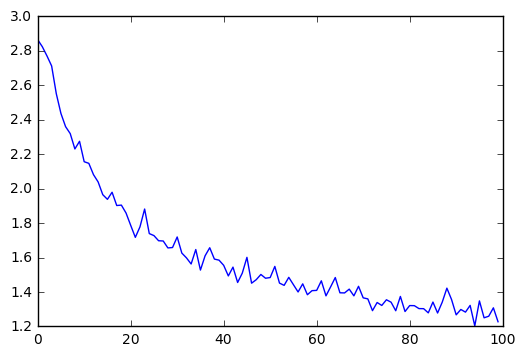

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

## 5. 评估模型
为了了解网络在不同类别上的表现如何，我们将创建一个混淆矩阵，指示每个实际语言（行）网络猜测的哪种语言（列）。为了计算混淆矩阵，使用evaluate()通过网络运行一组样本.

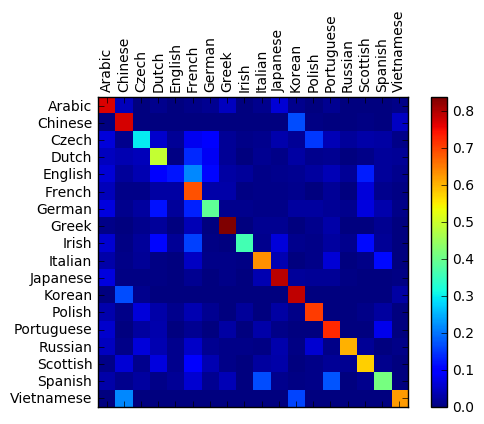

In [20]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i], hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i]+=1
    
for i in range(n_categories):
    confusion[i]/=(confusion[i].sum())
    
fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels(['']+all_categories,rotation=90)
ax.set_yticklabels(['']+all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


你可以从主轴上挑出明亮的点，它们可以显示出错误猜测的语言，例如：韩语猜测为汉语，意大利语猜测为西班牙语。希腊语的表现似乎很好，但是英语很差（可能是因为与其他语言的重叠较多）